# $K$-Nearest Neighbors ($K$-NN)

$k$-NN é um algoritmo de aprendizagem de máquina supervisionado que pode ser usado tanto para classificação quanto para regressão.

É um algoritmo não paramétrico, onde a estrutura do modelo será determinada pelo dataset utilizado. Este algoritmo utiliza uma forma de aprendizado conhecida como "preguiçosa" ( _lazy_), a qual não utiliza de dados de treinamento para ajustar o modelo, deixando o treinamento mais rápido, mas por outro lado aumentando o tempo da etapa de teste. 

Outra desvantagem é que todas as amostras do dataset devem ser armazenados para serem utilizados na fase de teste, resultando numa demanda maior por memória.

## Como funciona o algoritmo KNN

O $K$-NN possui um hiperparâmetro denominado $k$, o qual dá o nome ao modelo e determina a quantidade de vizinhos de cada amostra. Para problemas de classificação binária, geralmente utilízamos valores ímpares de $k$ a fim de evitar empates. 

Imagine, por exemplo, que gostariamos de classificar uma nova amostra entre classe 1 e classe 2 utilizando um valor de $k=1$. Tudo o que temos que fazer é encontrar o ponto mais próximo (podemos considerar diferentes distâncias, como Euclidiana, Hamming, Manhattan, etc.) dessa nova amostra e atribuir a ela o rótulo dessa amostra mais proxima. A imagem abaixo ilustra o exemplo:

<img src="assets/knn_k1.png" width="400"/>


Após identificar o ponto mais próximo e e seu rótulo (Ex.: Classe A), podemos predizer a classe novo ponto. 
Uma melhor abordagem seria, em vez de considerar apenas o vizinho mais próximo, fazer uma votação considerando a classe atribuída pelos $k$-vizinhos mais próximos.

## Passo a passo

1. Calcular a distância da nova amostra para todos os pontos
2. Encontrar os pontos/vizinhos mais próximos
3. Votar a label para o ponto a ser previsto

<img src="assets/stepByStep.png" width="700"/>


# Predizendo a imagem de lesmas do mar com $K$-NN

Para ilustrar o nosso algoritmo, vamos utilizar o dataset Abalone, que contém informações sobre um grande número de lesmas do mar.

<img src="assets/abalone.jfif" width="500"/>


A idade de um abalone pode ser encontrada cortando sua concha e contando o número de anéis. O dataset apresenta esse número de anéis, assim como outras medidas físicas.

O nosso objetivo aqui é conseguir estimar a idade do abalone baseando-se apenas nessas outras medidas físicas, permitindo conhecer a idade sem contar os anéis.

## importando o dataset

Considerando uma abordagem diferente, vamos utilizar o pacote Pandas para importar o dataset do repositório da [UCI](https://archive.ics.uci.edu/ml/datasets.php):

In [1]:
import pandas as pd
url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases"
    "/abalone/abalone.data"
)
# com o pandas, conseguimos ler um arquivo CSV diretamente de uma URL
abalone = pd.read_csv(url, header=None)

# mostrar os 5 primeiros registros
abalone.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Os nomes das colunas estão no arquivo abalone.names, disponível no [repositório](https://archive.ics.uci.edu/ml/datasets/abalone). Podemos adicioná-los no dataframe da seguinte maneira:

In [2]:
abalone.columns = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Shucked weight",
    "Viscera weight",
    "Shell weight",
    "Rings",
]
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Como o objetivo é estimar a idade baseado apenas em dados físicos, podemos eliminar a coluna sexo usando o comando `.drop`.


In [3]:
abalone = abalone.drop("Sex", axis=1)
abalone.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Estatísticas descritivas do dataset Abalone

Uma abordagem interessante quando trabalhamos com machine learning e dados no geral é analisar os dados para ter uma ideia de com o que estamos trabalhando. 

Como nosso `target` ou rótulo nesse caso são os anéis (coluna _ring_), podemos começar analisando isso. Um histograma nos dá uma visão geral do intervalo de idades que iremos encontrar:

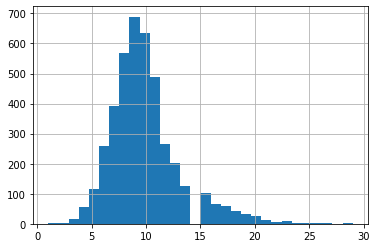

In [4]:
import matplotlib.pyplot as plt
abalone["Rings"].hist(bins=30)
plt.show()

O histograma mostra que a grande maioria das conchas tem entre 5 e 15 anéis, mas também existem algumas com 25 ou mais. Os abalones mais velhos tem poucas amostras nesse dataset, o que parece intuitivo, uma vez que a distribuição das idades é geralmente enviesada nesse sentido em processos naturais.

Uma segunda exploração que pode ser relevante seria encontrar quais variáveis podem ter uma correlação forte com a idade. Uma correlação forte entre uma variável independente e o nosso rótulo pode ser um bom dinal, e confirmaria que medidas físicas e idade estão relacionadas.

Podemos observar a matriz de correlação completa. As correlações mais importantes são aquelas com a variável `Rings`, que será o nosso rótulo. Podemos obter essas correlações da seguinte maneira:

In [5]:
correlation_matrix = abalone.corr()
correlation_matrix["Rings"]

Length            0.556720
Diameter          0.574660
Height            0.557467
Whole weight      0.540390
Shucked weight    0.420884
Viscera weight    0.503819
Shell weight      0.627574
Rings             1.000000
Name: Rings, dtype: float64

Olhando os coeficientes de correlação com a variável `Rings`, podemos concluir que existe ao menos alguma corrlação entre as medidas e a idade, ainda que não sejam muito altas (correlações mais altas indicam classificações mais simples).

Pandas oferece muitas outras possibilidades de exploração de dados. Esse [link](https://realpython.com/pandas-python-explore-dataset/) contém varios exemplos.


# Construindo um classificador $K$-NN passo-a-passo

Uma diferença do $K$-NN em relação à maioria dos algoritmos de machine learning é que os calculos para ajustar o modelo são executados no momento da predição em vez da etapa de treinamento. Quando novos pontos são apresentados, como o nome indica, ele encontra os vizinhos mais próximos e atribui a ele o rótulo da maioria.

A ideia geralmente faz sentido, quando pensamos que provavelmente nossos vizinhos mais próximos podem ter uma situação socio-econômica similar, pode levar os filhos na mesma escola, etc. Em outras nem tanto, como predizer sua cor favorita baseado na cor favorita de seus vizinhos.

## Definindo "Mais próximo" matematicamente

Para encontrar o vizinho mais próximo, a formulação matemática mais simples é usando a distância Euclidiana. Considerando que estamos lidando com distância entre vetores, podemos representar da seguinte maneira:

<img src="assets/distancia.png" width="500"/>

Na imagem temos o ponto azul em (2,2) e verde em (4,4). Para computar a distância entre eles, podemos começar computando a diferença entre os vetores em cada eixo, o que forma um angulo de 90̣° (um triângulo). A linha conhectando os vetores azul e verde é a hipotenusa desse triângulo, que pode ser computada usando o teorema de pitágoras para nosso caso 2-D.

Generalizando para casos de maior dimensionalidade, o comprimento desse vetor (no caso, a hipotenusa) é chamado de norma. A norma é um valor positivo que indica a magnitude de um vetor, e pode ser computado da seguinte maneira:

\begin{equation}
d(a,b) = \sqrt{(a_1-b_1)^2 + (a_2-b_2)^2 + \dots + (a_n-b_n)^2}
\end{equation}

A formula computa a distância considerando a diferença ao quadrado em cada uma das dimensões e depois tirando a raiz quadrada da soma de todos.

Em Python, podemos fazer isso utilizando a função `linalg.norm()` do numpy:

In [6]:
import numpy as np
a = np.array([2, 2])
b = np.array([4, 4])
np.linalg.norm(a - b)

2.8284271247461903

## Encontrando o vizinho mais próximo

Agora que sabemos computar a distância entre qualquer par de pontos, podemos usar isso para encontrar os vizinhos mais próximos de uma amostra de teste.

Voltando ao problema do dataset Abalone, vamos converter nosso DataFrame Pandas para gerar um conjunto de dados e computar o $K$-NN. Podemos converter um DataFrame Pandas para numpy usando o atributo .values.


In [7]:
X = abalone.drop("Rings", axis=1)
X = X.values
y = abalone["Rings"]
y = y.values
print(X.shape)
print(y.shape)

(4177, 7)
(4177,)


Em vez de separar em treinamento e teste, vamos simplesmente criar uma amostra para teste "na mão":

In [8]:
new_data_point = np.array([
    0.569552,
    0.446407,
    0.154437,
    1.016849,
    0.439051,
    0.222526,
    0.291208,
])

Em seguida computamos a distância entre esse ponto e cada ponto no dataset Abalone:

In [9]:
distances = np.linalg.norm(X - new_data_point, axis=1)

# Uma distância para cada amostra
distances.shape

(4177,)

Temos um vetor de distâncias, e precisamos encontrar os $k=3$ vizinhos mais próximos. Para isso, precisamos encontrar os IDs das menores distâncias. Podemos usar o metodo `.argsort()` para ordenar o array do menor para o maior, e pegar os índices dos $k$ menores elementos:

In [10]:
k = 3
nearest_neighbor_ids = distances.argsort()[:k]
nearest_neighbor_ids

array([4045, 1902, 1644])

Esses IDs nos mostram os 3 vizinhos mais próximos do nosso ponto `new_data_point`. Na sequência, vamos ver como estimar o seu valor baseado na votação entre esses vizinhos.

## Votando ou tirando a média de múltiplos vizinhos

Após identificar os indices dos vizinhos mais próximos da nossa lesma do mar de idade desconhecida, combinamos o `target` dos vizinhos para predizer o do nosso ponto.

Primeiramente, vamos analizar qual é o "rótulo" de cada vizinho:

In [11]:
nearest_neighbor_rings = y[nearest_neighbor_ids]
nearest_neighbor_rings

array([ 9, 11, 10])

Agora que sabemos os valores das idades dos 3 vizinhos, podemos combiná-los numa predição para nosso ponto. Essa combinação é diferente para tarefas de regressão e classificação.

### Regressão - computando a média

Problemas de regressão tem como saída um valor numérico. Nesse sentido, a predição é dada pela média dos valores dos rotulos dos vizinhos:

In [12]:
prediction = nearest_neighbor_rings.mean()
prediction

10.0

### Moda para classificação

Problemas de classificação esperam como saída predições categóricas. Nesse caso, em vez de calcular a média, podemos computar a moda, i.e., o valor que mais ocorre entre todos os $k$ vizinhos mais próximos.

Se existem multiplas modas, existem multiplas soluções possíveis, e teremos que escolher a solução vencedora de forma aleatória. Poderiamos também considerar a distância entre os vizinhos, em que a moda dos vizinhos mais próximos prevalecem.

Podemos computar a moda usando a função `mode()` do SciPy. Como o caso do Abalone não é um bom exemplo de classificação, podemos verificar o exemplo da função mode da seguinte forma:

In [13]:
import scipy.stats
class_neighbors = np.array(["A", "B", "B", "C"])
scipy.stats.mode(class_neighbors)

ModeResult(mode=array(['B'], dtype='<U1'), count=array([2]))

## Usando $K-$-NN no scikit-learn

Como de costume, primeiramente dividimos os dados em treinamento e teste:

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345
)

### Criando e ajustando o modelo

In [15]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)

knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

### Inspecionando o modelo

Uma boa métrica para avaliar o resultado em problemas de regressão é o [root-mean-square error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation), que é computado da seguinte forma:

1. computa a diferença entre o valor real e o valor estimado de cada ponto.
2. computa o quadrado de cada diferença.
3. soma todas as diferenças ao quadrado.
4. calcula a raiz quadrada dos valores somados.

Para começar, podemos computar o RMSE sobre o conjunto de treinamento, para o qual, geralmente, é esperado um RMSE relativamente bom (baixo):

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

1.653705966446084

Agora, para uma resultado mais realista, vamos computar o RMSE sobre o conjunto de teste:

In [17]:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

2.375417924000521

### Plotando os resultados

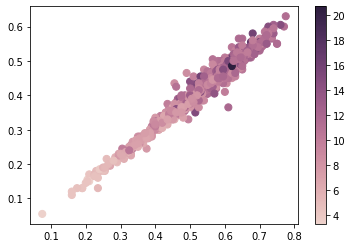

In [18]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
    X_test[:, 0], X_test[:, 1], c=test_preds, s=50, cmap=cmap
)
f.colorbar(points)
plt.show()

Nesse caso, estamos plotando as 2 primeiras colunas do dataset Abalone, i.e., comprimento e diâmetro. Podemos ver que essas 2 características estão fortemente correlacionadas.

Podemos confirmar essa tendência olhando os `targets` reais do dataset Abalone, simplesmente trocando `test_preds` por `y_test` no parâmetro c:


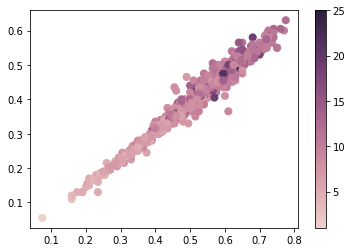

In [19]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cmap
)
f.colorbar(points)
plt.show()

Lembre que temos 7 dimensões nesse dataset. Fique a vontade para testar outras combinações e verificar se as demais características também estão correlacionadas entre si e entre a idade da lesma do mar.

# Exercícios:

1. Tente melhorar a performance do modelo otimizando o hiperparâmetro $k$ utilizando um grid search. Utilize valores de $k$ entre 1 e 50.

2. Otimize o modelo através de um grid search considerando também a média ponderada baseada na distância entre as amostras. Considere também valores de $k$ entre 1 e 50.